In [16]:
from PIL import Image
from IPython.display import display


In [17]:


def message_to_bin(message):
    '''Convert a string message to binary.'''
    binary_message = ''.join(format(ord(char), '08b') for char in message)
    return binary_message

def embed_message(image_path, message):
    '''Embed a message into an image.'''
    
    binary_message = message_to_bin(message)
    binary_message += '1111111111111110'  # Add a 16-bit delimiter which indicates end of the text
    image = Image.open(image_path).convert("RGB")
    pixels = list(image.getdata())
    new_pixels = []
    message_idx = 0

    for pixel in pixels:
        # If there's more message to embed, do it
        if message_idx < len(binary_message):
            # Embed 1 bit in each color channel (R, G, B)
            new_pixel = [(pixel[i] & ~1) | (int(binary_message[message_idx + i]) if message_idx + i < len(binary_message) else 0) for i in range(3)]
            message_idx += 3
        else:
            new_pixel = pixel
        new_pixels.append(tuple(new_pixel))
    

    # Create a new image with the modified pixels
    image.putdata(new_pixels)
    return image



Stenographic image generated


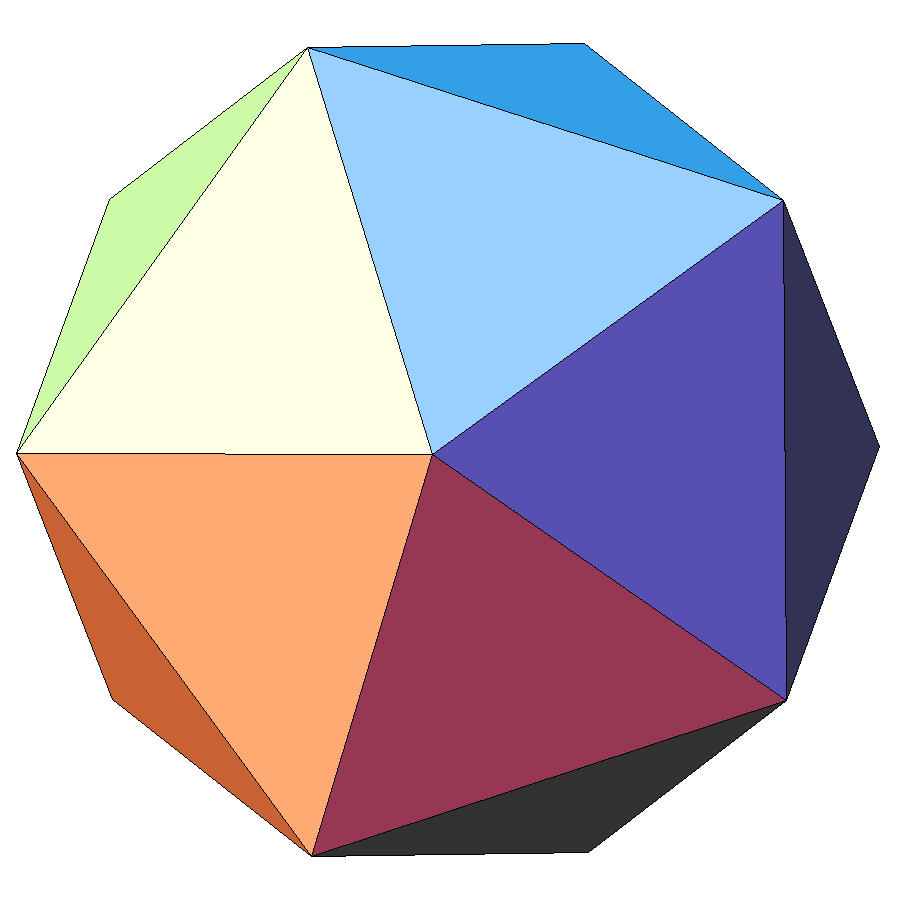

In [18]:
# Test the embed function
image_path = "ico.png" 
message = "Happy Birthday"
embedded_image = embed_message(image_path, message)
embedded_image.save("embedded_image.jpg")
print("Stenographic image generated")
# show image
display(embedded_image)

In [19]:
import hashlib
import math

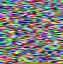

In [20]:


def text_to_binary(text):
    '''Convert text to its binary representation.'''
    return ''.join(format(ord(char), '08b') for char in text)

def binary_to_hashed_rgb(binary_string):
    '''Convert a binary string to an RGB tuple using SHA-256 hash.'''
    sha256_hash = hashlib.sha256(binary_string.encode()).hexdigest()
    # Extract RGB values from the hash
    return (int(sha256_hash[:2], 16), int(sha256_hash[2:4], 16), int(sha256_hash[4:6], 16))

def generate_image_from_text(text):
    '''Generate an image from the binary representation of text with height of 1 pixel.'''
    binary_repr = text_to_binary(text)
    
    # Ensure that the binary representation length is a multiple of 24
    while len(binary_repr) % 24 != 0:
        binary_repr += '0'
    
    # Convert binary to RGB values
    pixels = [binary_to_hashed_rgb(binary_repr[i:i+24]) for i in range(0, len(binary_repr), 24)]
    
    # Set width to the number of pixels and height to 1
    width = len(pixels)
    height = 1
    
    # Create the image
    image = Image.new('RGB', (width, height))
    image.putdata(pixels)
    return image


def generate_normalized_image_from_text(text, width=256):
    '''Generate an image with a normalized width from the binary representation of text.'''
    # Generate the image from text
    image = generate_image_from_text(text)
    
    # Resize the image to the desired width while keeping the height as 1
    image = image.resize((width, 1))
    return image

def stack_images_vertically(images):
    '''Stack a list of images vertically.'''
    total_width = images[0].width
    total_height = sum(img.height for img in images)
    
    # Create a blank image with the calculated width and height
    stacked_image = Image.new('RGB', (total_width, total_height))
    
    # Paste each image into the stacked image
    y_offset = 0
    for img in images:
        stacked_image.paste(img, (0, y_offset))
        y_offset += img.height
        
    return stacked_image

# Sample list of phrases
phrases = ["Happy Birthday", "Best Wishes", "Congratulations", "Party Time", "Cheers", "With Love"]

# Read the content of the text file
with open("cookie.txt", "r") as file:
    content = file.read()

# Determine the number of segments and segment length
num_segments = int(math.sqrt(len(content)))
segment_length = len(content) // num_segments

# Split the text into segments
segments = [content[i:i+segment_length] for i in range(0, len(content), segment_length)]

# Adjust the last segment if there's any leftover content
if len(segments[-1]) < segment_length:
    segments[-1] += " " * (segment_length - len(segments[-1]))

segments[:5]  # Display the first 5 segments for verification

# Generate normalized images for each segment and stack them
images = [generate_normalized_image_from_text(segment, width=num_segments) for segment in segments]
final_square_image = stack_images_vertically(images)

# show image in jupyter notebook

display(final_square_image)



# Generate normalized images for each phrase and stack them
# images = [generate_normalized_image_from_text(phrase) for phrase in phrases]
# final_image = stack_images_vertically(images)
# final_image.show()


# # Test the function with a sample text
# text_sample = "hello. "
# image_from_text = generate_image_from_text(text_sample)
# image_from_text.show()

In [12]:
# Description: This file contains functions to encrypt and decrypt data using AES.
# Run: pip install pycryptodome
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes



In [13]:

# Encrypting
def encrypt_file(filename):
    # Read file contents
    with open(filename, 'r') as file_in:
        data = file_in.read()
    file_in.close()

    key = get_random_bytes(16)  # Generate a random key
    # write key to a file called key.txt
    with open('key.txt', 'wb') as file_key:
        file_key.write(key)

    file_key.close()

    cipher = AES.new(key, AES.MODE_EAX)
    ciphertext, tag = cipher.encrypt_and_digest(data.encode('utf-8'))

    # write ciphertext to a file called encrypted.txt
    with open('encrypted.bin', 'wb') as file_out:
        [file_out.write(x) for x in (cipher.nonce, tag, ciphertext)]
    file_out.close()

In [14]:
def decrypt_file(filename):
    # Read encrypted contents
    with open(filename, 'rb') as file_in:
        nonce, tag, ciphertext = [file_in.read(x) for x in (16, 16, -1)]
    file_in.close()

    # Read key
    with open('key.txt', 'rb') as file_key:
        key = file_key.read()
    file_key.close()

    cipher = AES.new(key, AES.MODE_EAX, nonce)
    data = cipher.decrypt_and_verify(ciphertext, tag)

    # write decrypted contents to a file called decrypted.txt
    with open('decrypted.txt', 'wb') as file_out:
        file_out.write(data)
    file_out.close()

In [15]:
choice = input("Encrypt or decrypt? (e/d): ")
if choice == 'e':
    # Here, you can either hardcode a key, generate one, or ask the user to provide one.
    encrypt_file('card.txt')
elif choice == 'd':
    decrypt_file('encrypted.bin')